In [1]:
import numpy as np
import netCDF4 as nc
import glob
import os
from scipy.interpolate import PchipInterpolator

import matplotlib as mpl
font = {'family' : 'sans',
        'size'   : 12}

mpl.rc('font', **font)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator, LogLocator, MaxNLocator
import matplotlib.pyplot as plt

import pandas as pd
from cmcrameri import cm


In [2]:
import utils.load_grid as lg

In [3]:
from proteus.config import read_config
from proteus.utils.plot import observer_bands, dict_colors, vol_latex

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# %matplotlib widget

In [5]:
def readncdf(f):

    ds = nc.Dataset(f)
    vars = list(ds.variables.keys())

    nlev_c = len(ds.variables ["p"][:])
    nlev_l = len(ds.variables["pl"][:])
    tsurf  = float(ds.variables["tmp_surf"][:])
    psurf  = float(ds.variables["pl"][-1])
    gases  = [str(bytearray(s).decode()).strip() for s in ds.variables["gases"][:]]
    asf    = float(ds.variables["toa_heating"][:])

    data = {
        "nlev_c":       nlev_c,
        "nlev_l":       nlev_l,
        "tmp_surf":     tsurf,
        "psurf":        psurf,
        "gases":        gases,
        "toa_heating":  asf,
    }

    for k in vars:
        if k in data.keys():
            continue
        var = ds.variables[k][:]
        try:
            data[k] = np.array(ds.variables[k][:], dtype=float)
        except:
            continue

    ds.close()
    return data

def readrun(f, stride=1):
    print("Reading files in '%s'..." % f)
    ncdfs = glob.glob(f+"/data/*_atm.nc")
    if len(ncdfs) == 0:
        raise Exception("No files found!")

    years = [float(s.split("/")[-1].split("_")[0]) for s in ncdfs]

    if stride < 0:
        mask = [np.argsort(years)[-1]]
    else:
        mask = np.argsort(years)[::int(stride)]

    ncdfs = np.array([ncdfs[i] for i in mask])
    years = np.array([years[i] for i in mask])
    data  = np.array([readncdf(f) for f in ncdfs])

    print("    Done reading %d files" % len(years))
    print("    Final time = %1.3e years" % years[-1])
    return years, data

def read_helpfile(fpath):
    return pd.read_csv(fpath, sep=r'\s+')



### original data

In [6]:
title = "LTT 3780 b"
ori_path = os.path.join(os.environ.get("HOME"),"analysis/data/article_data/mnras_proteus_agni/plots/chem/ori/atm.nc")
ori_data = readncdf(ori_path)

### re-simulated data

In [7]:
new_path = os.path.join(os.environ.get("HOME"),"analysis/data/article_data/mnras_proteus_agni/plots/chem/new/atm.nc")
new_data = readncdf(new_path) 

### compare

In [8]:
print(new_data["x_gas"].shape)
print(len(new_data["gases"]))

(60, 38)
38


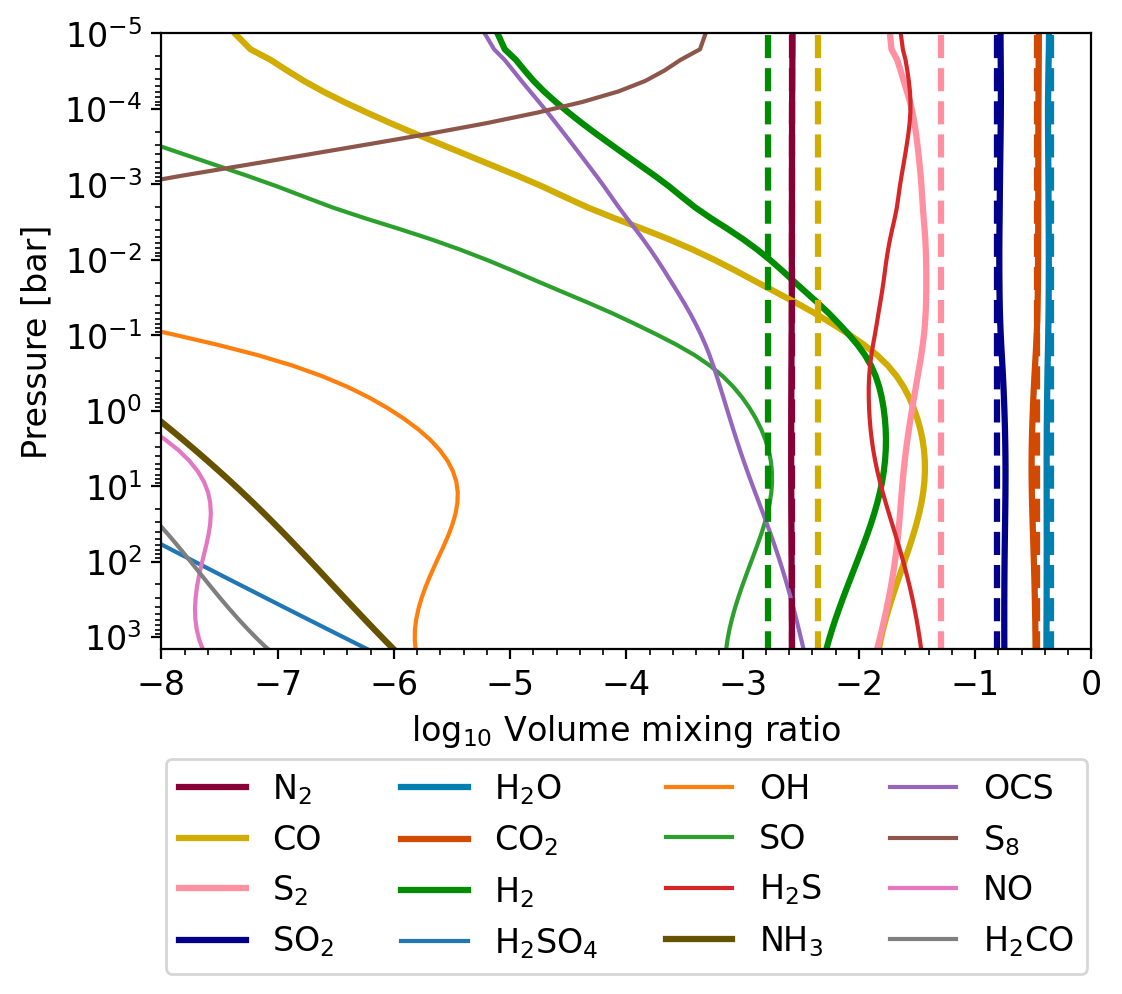

In [12]:
fig,axb = plt.subplots(1,1, figsize=(6,4))

xlim = [-8, 0]
lw=1.5
lw_factor=1.5

# plot new mixing ratios
for i,g in enumerate(new_data["gases"]):
    y = new_data["p"]/1e5
    x = new_data["x_gas"][:,i]

    if np.amax(x) < 10**xlim[0]:
        continue 
    x = np.log10(x)

    if g in dict_colors.keys():
        col = dict_colors[g]
        _lw = lw*lw_factor
    else:
        _lw = lw
        col = None
    axb.plot(x,y, color=col, label=lg.latexify(g), lw=_lw)

# plot old mixing ratios
for i,g in enumerate(ori_data["gases"]):
    y = ori_data["p"]/1e5
    x = np.log10(ori_data["x_gas"][:,i])

    if g in dict_colors.keys():
        col = dict_colors[g]
        _lw = lw*lw_factor
    else:
        _lw = lw
        col = None
    axb.plot(x,y, color=col, ls='dashed', lw=_lw)


# decorate
axb.set_yscale("log")
axb.set_ylim(bottom=np.amax(new_data["pl"]/1e5), top=np.amin(new_data["pl"])/1e5)
axb.set_ylabel("Pressure [bar]")

axb.set_xlim(left=xlim[0], right=xlim[1])
axb.set_xlabel("log$_{10}$ Volume mixing ratio")
axb.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
axb.xaxis.set_major_locator(MultipleLocator(1))
axb.xaxis.set_minor_locator(MultipleLocator(0.2))

# save
plt.show()
for fmt in ["png","pdf"]:
    fig.savefig("output/chem_compare.%s"%fmt,bbox_inches='tight', dpi=300)

In [10]:
# check temperature difference
print("temperature difference")
t_ori = ori_data["tmpl"]
t_new = new_data["tmpl"]
t_dif = np.abs(t_new - t_ori)
print(np.amax(t_dif))
print(np.argmax(t_dif))
print(np.amax(t_dif)/t_ori[np.argmax(t_dif)]*100)

# check mmw difference
print(" ")
print("mmw difference")
m_ori = ori_data["mmw"]
m_new = new_data["mmw"]
m_dif = np.abs(m_new - m_ori)
print(np.amax(m_dif))
print(np.argmax(m_dif))
print(np.amax(m_dif)/m_ori[np.argmax(m_dif)]*100)


temperature difference
4.481033455416309
29
0.3763396752515689
 
mmw difference
0.00045727723690389827
41
1.2576102733826102
